# Demo P4 Self-Attention

In this demo, we will analyze the equivariance properties of p4 group-equivariant self-attention models (i.e., to rotations by 90 degrees).

First, we will demonstrate the translation equivariance of the model and, subsequently, we will perform an analysis into the rotation equivariance properties of the model.

## Importing Libraries
Add the library to the system path via the relative folder structure:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)

Import the necessary libraries:

In [3]:
# torch
import torch
import torch.nn as nn
# project
import g_selfatt
# other
from matplotlib import pyplot as plt
import importlib

## P4 Self-Attention Layers

In what follows we take:

* a random noise image f as input
* apply a sequence of p4 self-attention layers to it f -> N(f)
* translate the input (T(f)) via the action of the translation group on f and send it through the same sequence of layers and (T(f) -> N(T(f)))
* then we test the equivariance property T'(N(f))=N(T(f)) In the above T denotes the translation operator of 2D images, and T' denotes the translation operator on feature maps.

Subsequently, we repeat the process for rotations:

* apply a sequence of p4 self-attention layers to it f -> N(f)
* rotate the input (R(f)) via the action of the rotation group on f and send it through the same sequence of layers and (R(f) -> N(R(f)))
* then we test the equivariance property R'(N(f))=N(R(f)) In the above R denotes the rotation operator of 2D images, and R' denotes the rotation operator (shift-twist) of SE(2) images, which is a planar rotation and a periodic shift along the extra rotation axis.


Now, let us create a net with two self-attention layers, with a total of 3 ** 2 heads:

### The input feature map

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


Image tensor shape: torch.Size([4, 3, 32, 32])
Label tensor: tensor([1, 9, 9, 4])


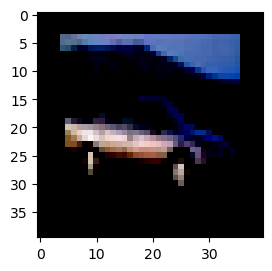

In [4]:
Nxy = 32 # This spatial dimension
N_in = 3 # This many feature channels
B = 4 # Batch size
# # For now we work with a placeholder
# inputs = torch.randn([B,N_in,Nxy,Nxy], dtype=torch.float32)
# inputs[:,:, :4, :] = 0.0 
# inputs[:,:, :, :4] = 0.0 
# inputs[:,:, -4:,:] = 0.0 
# inputs[:,:, :, -4:] = 0.0 

# import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn.functional as F


# Define transformations for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load the MNIST dataset with the transformation
mnist_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Extract 2 samples using Subset
indices = [4, 1, 2, 3]  # Indices of the samples to extract
subset = Subset(mnist_dataset, indices)

# Use DataLoader to fetch the subset
data_loader = DataLoader(subset, batch_size=B, shuffle=False)

# Extract the tensor directly from the DataLoader
inputs, labels = next(iter(data_loader))  # Get the first batch

# Print the extracted tensors
print("Image tensor shape:", inputs.shape)  # (batch_size, channels, height, width)
print("Label tensor:", labels)  # Corresponding labels as a tensor

# # For now we work with a placeholder
# # inputs = torch.randn([B,N_in,Nxy,Nxy], dtype=torch.float32)
# inputs[:,:, :4, :] = 0.0 
# inputs[:,:, :, :4] = 0.0 
# inputs[:,:, -4:,:] = 0.0 
# inputs[:,:, :, -4:] = 0.0

inputs = F.pad(inputs, pad=(4, 4, 4,4), mode='constant', value=0) 
def show_image(image_tensor, label):
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
    plt.imshow(image)
    # plt.title(f"Label: {class_labels[label]}")
    plt.axis('on')

# Plot the images
plt.figure()

plt.subplot(1, 2, 1)
show_image(inputs[0], labels[0])


### Attention Layers

In [5]:
# Layer parameters
num_heads = 3 ** 2

# Construct the group we want to test equivariance on.
num_elements = 4
group = g_selfatt.groups.SE2(num_elements)

# Construct the layers.
sa_1 = g_selfatt.nn.LiftLocalSelfAttention(
        group=group,
        in_channels=N_in,
        mid_channels=N_in,
        out_channels=N_in * 2,
        num_heads=num_heads,
        attention_dropout_rate=0.,
        patch_size=3 
        # max_pos_embedding=9
        )

# sa_1 = g_selfatt.nn.LiftConvAttention(
#         group=group,
#         in_channels=N_in,
#         mid_channels=N_in,
#         out_channels=N_in * 2,
#         num_heads=num_heads,
#         attention_dropout_rate=0.,
#         patch_size=3, 
#         max_pos_embedding=9
#         )

sa_2 = g_selfatt.nn.GroupConvAttention(
    group=group,
        in_channels=N_in * 2, 
        mid_channels=N_in, 
        out_channels=N_in * 4,
        num_heads=num_heads,
        attention_dropout_rate=0,
        # patch_size=3,
        max_pos_embedding=9)
    

### Test the network - Translation Equivariance

We create random noise input and translated noise:

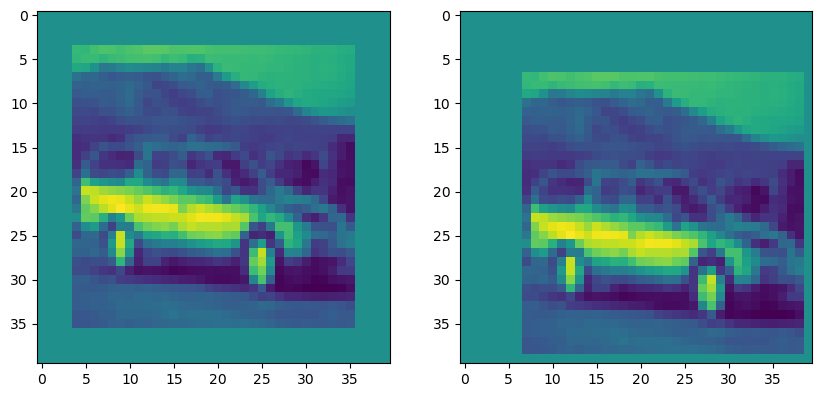

In [6]:
input_tensor = inputs
input_tensor_trans = torch.roll(inputs, (3,3), dims=(-2,-1))

f_size = 4

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_trans.numpy()[0,0,:,:,])
plt.show()

Pass the original random signal to the network and then its translated version

In [7]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_trans = sa_1(input_tensor_trans)
out_2_trans = sa_2(out_1_trans)

Let's compare the results. Recall that now all feature maps are a funtion of the group. Thus it is composed of group.num_elements 'channels'.

FIRST LAYER:

The original input.


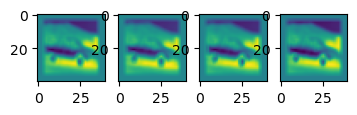

The translated input.


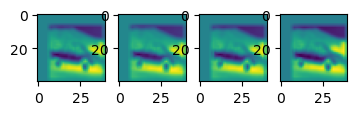


 SECOND LAYER:

The original input.


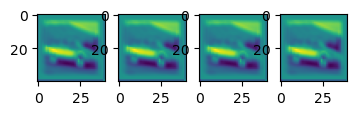

The translated input.


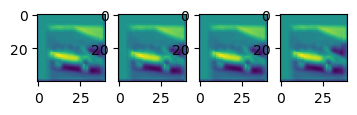

In [8]:
print('FIRST LAYER:\n')

print( 'The original input.')
plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:])
plt.show()

print( 'The translated input.')
plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1_trans.detach().numpy()[0,0,i,:,:])
plt.show()

print('\n SECOND LAYER:\n')

print( 'The original input.')
plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:])
plt.show()

print( 'The translated input.')
plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2_trans.detach().numpy()[0,0,i,:,:])
plt.show()

### Test the network - Rotation Equivariance

Now, let's analyze what occurs if the input image is rotated. Lets first see the input

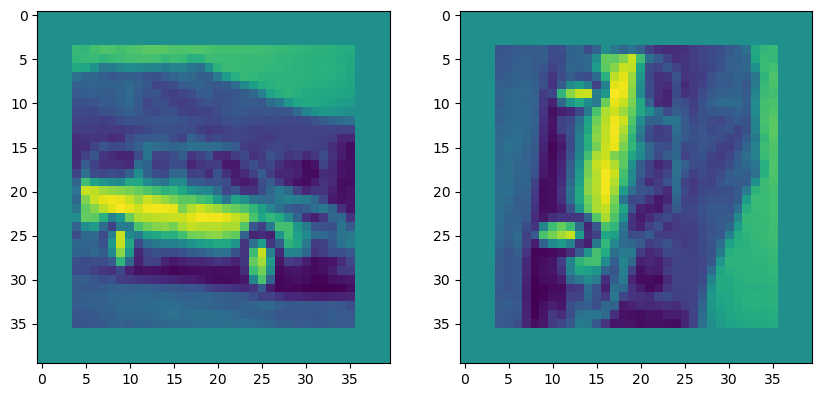

In [9]:
input_tensor = inputs
input_tensor_90 = inputs.rot90(k=-1, dims=[-2,-1])

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_90.numpy()[0,0,:,:,]);
plt.show()

Pass the original random signal to the network and then its rotated version

In [10]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_90 = sa_1(input_tensor_90)
out_2_90 = sa_2(out_1_90)

Let's compare the results

FIRST LAYER:

The original input.


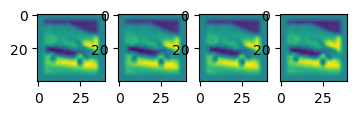

The rotated input.


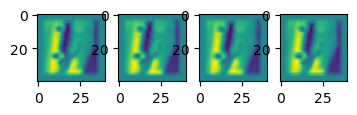


 SECOND LAYER:

The original input.


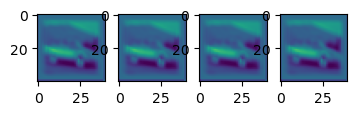

The rotated input.


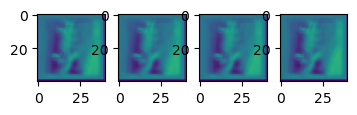

In [11]:
print('FIRST LAYER:\n')
vmax = torch.max(out_1[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_1_90[0,0,:,:,:]).item() < vmax else torch.max(out_1_90[0,0,:,:,:]).item()
vmin = torch.min(out_1[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_1_90[0,0,:,:,:]).item() < vmin else torch.min(out_1_90[0,0,:,:,:]).item()

print( 'The original input.')
plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.show()

print( 'The rotated input.')
plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1_90.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.show()

print('\n SECOND LAYER:\n')
vmax = torch.max(out_2[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_2_90[0,0,:,:,:]).item() < vmax else torch.max(out_2_90[0,0,:,:,:]).item()
vmin = torch.min(out_2[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_2_90[0,0,:,:,:]).item() < vmin else torch.min(out_2_90[0,0,:,:,:]).item()

print( 'The original input.')

plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.show()

print( 'The rotated input.')
plt.subplots(1,group.num_elements, figsize=(f_size,f_size))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2_90.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.show()

As we can see, the responses are equivalent for rotated versions of the same image. Up to a permutation of the axes (1 to the right) and a rotation of each feature map (by a corresponding rotation to that of the input).

**DISCLAIMER!** Though the feat.maps look similar, they are not equal. To check this, look at the following example.

In [12]:

abs(out_1[0,0,0] - out_1[0,0,1]).max(), abs(out_1[0,0,0] - out_1[0,0,2]).max()

(tensor(0.0686, grad_fn=<MaxBackward1>),
 tensor(0.0980, grad_fn=<MaxBackward1>))

In [13]:

abs(out_1_90[0,0,1] - out_1_90[0,0,2]).max(), abs(out_1_90[0,0,1] - out_1_90[0,0,3]).max()

(tensor(0.0686, grad_fn=<MaxBackward1>),
 tensor(0.0980, grad_fn=<MaxBackward1>))

The max. value is different accross same channels but, for rotated versions, they are equal at the corresponding permuted channel locations.

torch.Size([40, 40])
tensor(0.0413, grad_fn=<MeanBackward0>)


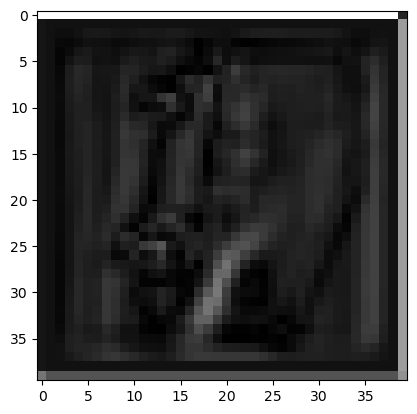

In [14]:
print(out_2[0,0,0].shape)
out_rot = out_2.rot90(k=-1, dims=[-2,-1])

res = abs(out_rot[0,0,0] - out_2_90[0,0,0] )

plt.imshow(res.detach().numpy(), cmap='gray')
print(res.mean())